# Visualize Coverage Dataset

In [1]:
import io
import json
import random
import sys

import folium
import matplotlib.cm as cm
import matplotlib.colors as colrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pyproj import Transformer
from shapely.affinity import scale
from shapely.geometry import Point, Polygon, mapping, shape
from shapely.ops import transform as shapely_transform

In [2]:
lambert93 = 'epsg:2154' # France metric system
wgs = 'epsg:4326'

transform_wgs_to_lambert93 = Transformer.from_crs(wgs, lambert93).transform
transform_lambert93_to_wgs = Transformer.from_crs(lambert93, wgs).transform

In [3]:
font_size = 20
plt.rcParams['font.size'] = font_size
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.family'] = 'serif'

## Load data

### Load Voronoi and VoronoiBoost polygons

In [4]:
filename = 'coverage/df_bs_Orange_Paris.pkl'
df_bs = pd.read_pickle(filename)
df_bs.head(5)

,id,lat,lon,voronoi_polygons,voronoi_boost_polygons,voronoi_grid,voronoi_boost_grid,x,y,xllcorner,yllcorner
0,0,48.888333,2.251111,"POLYGON ((48.88821180559187 2.255434027605475,...",[(POLYGON ((48.88821783126701 2.25556348468754...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",645085.508673,6.865629e+06,615000.0,6835600.0
1,1,48.887500,2.250278,"POLYGON ((48.88729166673638 2.2491666665, 48.8...",[(POLYGON ((48.88850705324522 2.24659380319924...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",645023.524092,6.865537e+06,615000.0,6835500.0
2,2,48.881389,2.390556,"POLYGON ((48.88372565861312 2.391194158189179,...",[(POLYGON ((48.8835871285528 2.391127252879346...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",655304.498546,6.864769e+06,625300.0,6834700.0
3,3,48.872778,2.242778,"POLYGON ((48.86450820259661 2.24060001345128, ...",[(POLYGON ((48.86658070154944 2.24090152361955...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",644457.873708,6.863906e+06,614400.0,6833900.0
4,4,48.841389,2.268889,"POLYGON ((48.8447192882161 2.269201877779334, ...",[(POLYGON ((48.84463985520487 2.26919432158761...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",646340.747703,6.860397e+06,616300.0,6830300.0


## Show results

In [5]:
small_bs_ids = [1521, 2305, 545, 2151, 1839, 307, 1047, 479]
big_bs_ids = [880, 148, 1704, 2214, 340, 1975, 1126, 1889, 153, 
              1845, 1512, 1800, 2095, 255, 1286, 86, 11, 1715, 
              1181, 1884, 1243, 443, 446, 2397, 112, 2203, 1331, 2031, 575]

lats = []
lons = []
for bs_id_index, bs_id in enumerate(big_bs_ids+small_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    lats.append(lat)
    lons.append(lon)

mean_lats = np.mean(lats)
mean_lons = np.mean(lons)
print(f'Centering the city at ({mean_lats:.3f}, {mean_lons:.3f}) 📌')

Centering the city at (48.854, 2.350) 📌


### Determine bbox of small area

In [6]:
lats = []
lons = []

for bs_id_index, bs_id in enumerate(small_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    lats.append(lat)
    lons.append(lon)

lat_0, lon_0, lat_1, lon_1 = np.min(lats), np.min(lons), np.max(lats), np.max(lons)
bbox = [[lat_0, lon_0], [lat_0, lon_1], [lat_1, lon_1], [lat_1, lon_0]]
bbox = Polygon(bbox)
bbox = scale(bbox, xfact=2.5, yfact=2.5)

### Small area VoronoiBoost 

In [7]:
values = []
for bs_id_index, bs_id in enumerate(small_bs_ids+big_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    voronoi = bs['voronoi_polygons']
    voronois_scaled_overlap = bs['voronoi_boost_polygons']
            
    for index, (voronoi_scaled_overlap, tau) in enumerate(voronois_scaled_overlap[::-1]):

        voronoi_scaled_overlap_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap).area

        if index != len(voronois_scaled_overlap)-1:
            voronoi_scaled_overlap_inside, tau_inside = voronois_scaled_overlap[::-1][index+1]
            voronoi_scaled_overlap_inside_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap_inside).area
            area = voronoi_scaled_overlap_area - voronoi_scaled_overlap_inside_area
            area = area/(100**2)
            tau_diff = tau - tau_inside
            density = tau_diff/area
            values.append(density)
        else:
            area = voronoi_scaled_overlap_area/(100**2)
            density = tau/area
            values.append(density)

my_cmap = plt.cm.get_cmap('Greens')
norm = colrs.LogNorm(vmin=min(values),  vmax=max(values))

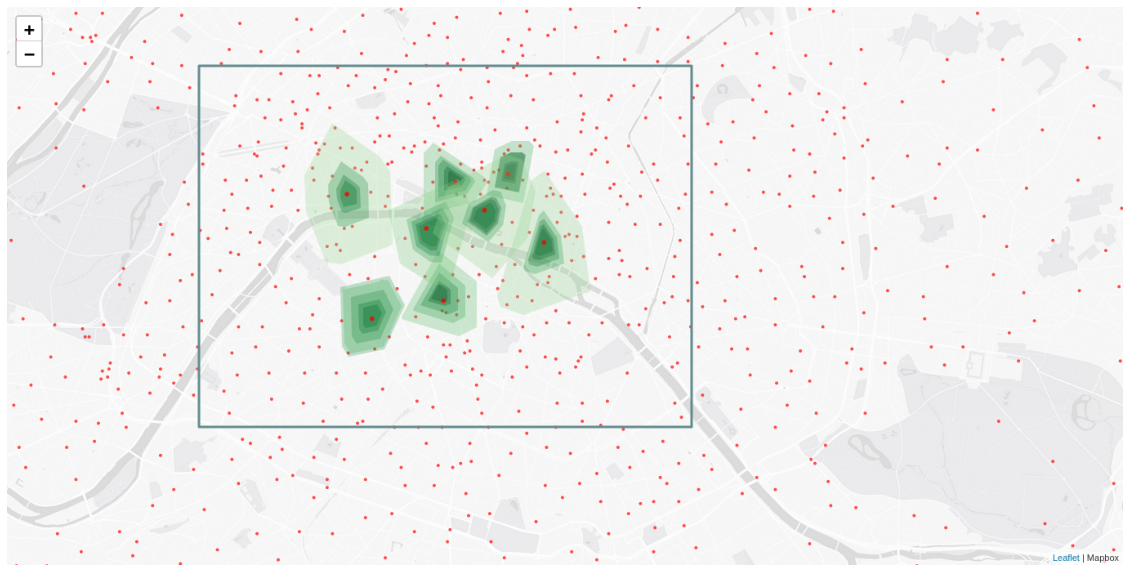

In [8]:
m = folium.Map(location=[mean_lats, mean_lons], zoom_control=True, zoom_start=13, 
                    tiles=f'https://api.mapbox.com/styles/v1/landys/cl9oxte8e00n715l3s5vuu13j/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')


# show all BSs
for bs in df_bs.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']
    
    folium.Circle(
        radius=30,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
    ).add_to(m)


for bs_id_index, bs_id in enumerate(small_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    voronoi = bs['voronoi_polygons']
    voronois_scaled_overlap = bs['voronoi_boost_polygons']

    for index, (voronoi_scaled_overlap, tau) in enumerate(voronois_scaled_overlap[::-1]):

        voronoi_scaled_overlap_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap).area
        area = voronoi_scaled_overlap_area/(100**2)
        density = tau/area

        if index != len(voronois_scaled_overlap)-1:
            voronoi_scaled_overlap_inside, tau_inside = voronois_scaled_overlap[::-1][index+1]
            voronoi_scaled_overlap_inside_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap_inside).area
            area = voronoi_scaled_overlap_area - voronoi_scaled_overlap_inside_area
            area = area/(100**2)
            tau_diff = tau - tau_inside
            density = tau_diff/area

        color = colrs.to_hex(my_cmap(norm(density)))

        folium.Polygon(mapping(voronoi_scaled_overlap)['coordinates'][0],
            color=color,
            fill_color=color,
            opacity = 0,
            fill_opacity = .3,
            weight=1.5,
        ).add_to(m)

    folium.Circle(
        radius=40,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

#Show center area
folium.Polygon(mapping(bbox)['coordinates'][0],
    color='#638B8E',
    fill_color='#638B8E',
    opacity = 1,
    fill_opacity = 0,
    weight=3,
).add_to(m)

# Show map as HTML (for local use)
# m

# Show map as Image (just for github)
img_data = m._to_png(1)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

### Big area VoronoiBoost

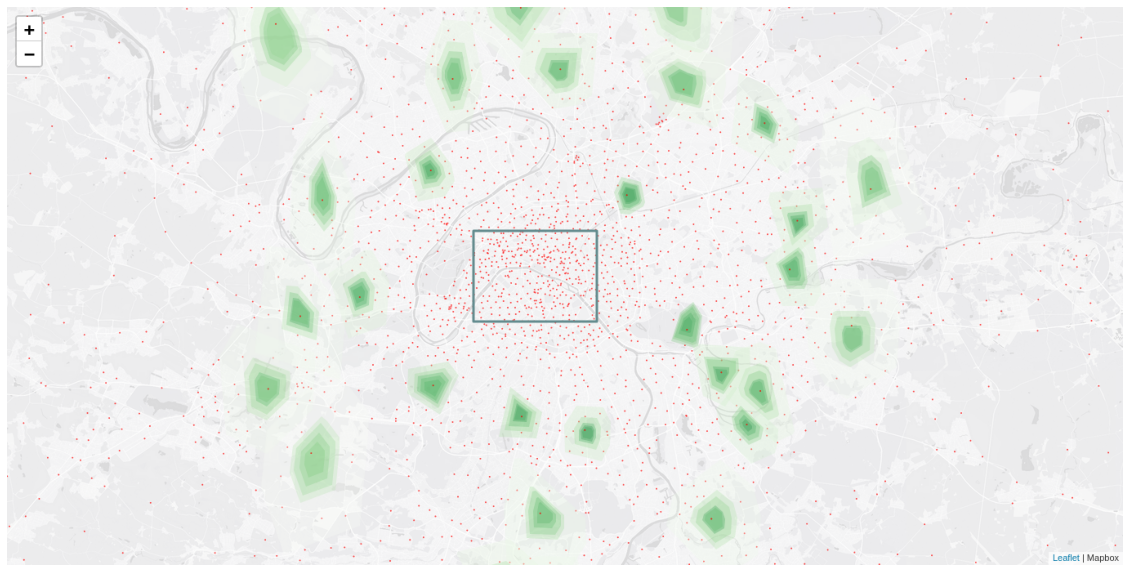

In [9]:
m = folium.Map(location=[mean_lats, mean_lons], zoom_control=True, zoom_start=11, 
                    tiles=f'https://api.mapbox.com/styles/v1/landys/cl9oxte8e00n715l3s5vuu13j/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

# show all BSs
for bs in df_bs.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']

    folium.Circle(
        radius=30,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
    ).add_to(m)



for bs_id_index, bs_id in enumerate(big_bs_ids):
    bs = df_bs[df_bs['id'] == bs_id].iloc[0]
    lat, lon = bs['lat'], bs['lon']
    voronoi = bs['voronoi_polygons']
    voronois_scaled_overlap = bs['voronoi_boost_polygons']


    for index, (voronoi_scaled_overlap, tau) in enumerate(voronois_scaled_overlap[::-1]):
        
        voronoi_scaled_overlap_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap).area
        area = voronoi_scaled_overlap_area/(100**2)
        density = tau/area
        
        if index != len(voronois_scaled_overlap)-1:
            voronoi_scaled_overlap_inside, tau_inside = voronois_scaled_overlap[::-1][index+1]
            voronoi_scaled_overlap_inside_area = shapely_transform(transform_wgs_to_lambert93, voronoi_scaled_overlap_inside).area
            area = voronoi_scaled_overlap_area - voronoi_scaled_overlap_inside_area
            area = area/(100**2)
            tau_diff = tau - tau_inside
            density = tau_diff/area

        color = colrs.to_hex(my_cmap(norm(density)))

        folium.Polygon(mapping(voronoi_scaled_overlap)['coordinates'][0],
            color=color,
            fill_color=color,
            opacity = 0,
            fill_opacity = .3,
            weight=1.5,
        ).add_to(m)

    folium.Circle(
        radius=40,
        location=[lat, lon],
        fill_color='red',
        fill_opacity=.7,
        opacity=0,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

#Show center area
folium.Polygon(mapping(bbox)['coordinates'][0],
    color='#638B8E',
    fill_color='#638B8E',
    opacity = 1,
    fill_opacity = 0,
    weight=3,
).add_to(m)


# Show map as HTML (for local use)
# m

# Show map as Image (just for github)
img_data = m._to_png(1)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

### Legend

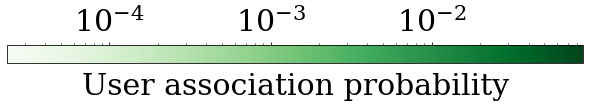

In [10]:
fig = plt.figure(figsize=(8, .25))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])

ax = fig.add_axes([0, 1, 1, 1])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, cax=ax, orientation='horizontal')
clb.set_label('User association probability', labelpad=10, size=1.5*font_size)
clb.ax.xaxis.set_ticks_position('top')
clb.ax.tick_params(labelsize=1.5*font_size)

plt.show()